# How to generate long-short trading signals with a Random Forest

## Imports & Settings

In [3]:
!pip install ipython-autotime
!pip install lightgbm

     |████████████████████████████████| 2.0 MB 8.9 MB/s eta 0:00:01
time: 4.25 s (started: 2021-05-01 13:55:48 +00:00)


In [4]:
import warnings
warnings.filterwarnings('ignore')

time: 610 µs (started: 2021-05-01 13:55:52 +00:00)


In [5]:
%matplotlib inline
%load_ext autotime

from time import time
from io import StringIO
import sys, os
from tqdm import tqdm

from itertools import product
from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from utils import MultipleTimeSeriesCV, format_time

sns.set_style('whitegrid')
np.random.seed(42) # for cv
idx = pd.IndexSlice
YEAR = 252

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 164 ms (started: 2021-05-01 13:55:52 +00:00)


In [6]:
### set path
import os
from pathlib import Path
path_home = os.getcwd()
path_home = Path(path_home)
path_data = path_home / 'data'
path_result = path_home / 'result'
if not path_result.exists():
    path_result.mkdir()

time: 982 µs (started: 2021-05-01 13:55:52 +00:00)


## Get Data

See the notebook [japanese_equity_features](03_japanese_equity_features.ipynb) in this directory for data preparation.

In [ ]:
!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_data.zip .
!unzip stooq_jp_data.zip

In [7]:
data = (pd.read_csv(path_data / 'stooq_jp_equities.csv', parse_dates=['date'])
          .set_index(['ticker','date'])
          .sort_index(level=['ticker','date'])      
       )
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2304509 entries, ('1332.JP', Timestamp('2010-01-04 00:00:00')) to ('9990.JP', Timestamp('2019-12-30 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ret_1            2303568 non-null  float64
 1   ret_rel_perc_1   2303568 non-null  float64
 2   ret_5            2299804 non-null  float64
 3   ret_rel_perc_5   2299804 non-null  float64
 4   ret_10           2295099 non-null  float64
 5   ret_rel_perc_10  2295099 non-null  float64
 6   ret_21           2284748 non-null  float64
 7   ret_rel_perc_21  2284748 non-null  float64
 8   ret_63           2245226 non-null  float64
 9   ret_rel_perc_63  2245226 non-null  float64
 10  PPO              2280984 non-null  float64
 11  NATR             2291335 non-null  float64
 12  RSI              2291335 non-null  float64
 13  bbl              2300745 non-null  float64
 14  bbu              2300745 non-nul

We start with 941 tickers.

In [116]:
len(data.index.unique('ticker'))

941

time: 25.6 ms (started: 2021-04-28 11:06:50 +00:00)


### Select universe of 250 most-liquid stocks

We rank the stocks by their daily average dollar volume and select those with the 250 lowest average ranks and thus highest average volumes for the 2010-2017 period.

In [5]:
prices = (pd.read_csv(path_data / 'stooq_jp_tse_stocks_prices.csv', parse_dates=['date'])
          .set_index(['ticker','date'])
          .sort_index(level=['ticker','date'])    
          .loc[idx[:, '2010': '2017'], :]
         )

time: 21 s (started: 2021-04-29 05:49:33 +00:00)


In [6]:
dollar_vol = prices.close.mul(prices.volume)
dollar_vol_rank = dollar_vol.groupby(level='date').rank(ascending=False)
universe = dollar_vol_rank.groupby(level='ticker').mean().nsmallest(250).index

time: 4.84 s (started: 2021-04-29 05:49:54 +00:00)


## MultipleTimeSeriesCV

For each fold, the train and test periods are separated by a `lookahead` number of periods and thus do not overlap:

In [8]:
def train_test_periods_msg(train_idx, test_idx, data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    msg = f'Training: {train_dates.min().date()}-{train_dates.max().date()} '
    msg += f' ({train.groupby(level="ticker").size().value_counts().index[0]:,.0f} days) | '
    msg += f'Test: {test_dates.min().date()}-{test_dates.max().date()} '
    msg += f'({test.groupby(level="ticker").size().value_counts().index[0]:,.0f} days)'
    print(msg)

time: 1.14 ms (started: 2021-05-01 13:56:30 +00:00)


In [8]:
cv = MultipleTimeSeriesCV(n_splits=36,
                          test_period_length=21,
                          lookahead=5,
                          train_period_length=2 * 252)

for i, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train_test_periods_msg(train_idx, test_idx, data)
    if i == 3:
        break

Training: 2017-10-24-2019-11-25  (508 days) | Test: 2019-12-02-2019-12-30 (21 days)
Training: 2017-09-22-2019-10-24  (508 days) | Test: 2019-10-31-2019-11-29 (21 days)
Training: 2017-08-23-2019-09-20  (508 days) | Test: 2019-09-30-2019-10-30 (21 days)
Training: 2017-07-24-2019-08-21  (508 days) | Test: 2019-08-28-2019-09-27 (21 days)
time: 10.4 s (started: 2021-04-29 05:49:59 +00:00)


## Model Selection: Time Period and Horizon

For the model selection step, we restrict training and validation sets to the 2010-2017 period.

In [9]:
cv_data = data.loc[idx[universe, :'2017'], :]
tickers = cv_data.index.unique('ticker')
cv_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 420082 entries, ('7203.JP', Timestamp('2010-01-04 00:00:00')) to ('4021.JP', Timestamp('2017-12-29 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ret_1            419868 non-null  float64
 1   ret_rel_perc_1   419868 non-null  float64
 2   ret_5            419012 non-null  float64
 3   ret_rel_perc_5   419012 non-null  float64
 4   ret_10           417942 non-null  float64
 5   ret_rel_perc_10  417942 non-null  float64
 6   ret_21           415588 non-null  float64
 7   ret_rel_perc_21  415588 non-null  float64
 8   ret_63           406600 non-null  float64
 9   ret_rel_perc_63  406600 non-null  float64
 10  PPO              414732 non-null  float64
 11  NATR             417086 non-null  float64
 12  RSI              417086 non-null  float64
 13  bbl              419226 non-null  float64
 14  bbu              419226 non-null  float64
 15  we

Persist the data to save some time when running another experiment:

In [11]:
cv_data.to_csv(path_data / 'stooq_jp_equities_cv.csv')
!zip -u stooq_jp_data.zip data/stooq_jp_equities_cv.csv

  adding: data/stooq_jp_equities_cv.csv (deflated 65%)
time: 24.5 s (started: 2021-04-28 01:39:03 +00:00)


We're picking prediction horizons of 1, 5, 10 and 21 days:

In [6]:
lookaheads = [1, 5, 10, 21]

time: 384 µs (started: 2021-04-30 13:57:52 +00:00)


## Baseline: Linear Regression

Since it's quick to run and quite informative, we generate linear regression baseline predictions. See [Chapter 7 - Linear Models](../07_linear_models) for details.

In [11]:
lr = LinearRegression(n_jobs=-1)

time: 571 µs (started: 2021-04-29 05:50:25 +00:00)


In [12]:
labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

time: 12.1 ms (started: 2021-04-29 05:50:27 +00:00)


### CV Parameters

We set five different training lengths from 3 months to 5 years, and two test periods as follows:

In [13]:
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]
val_length = 2 * YEAR

time: 648 µs (started: 2021-04-29 05:50:31 +00:00)


Since linear regression has no hyperparameters, our CV parameters are the cartesian product of prediction horizon and train/test period lengths:

In [14]:
test_params = list(product(lookaheads, train_lengths, test_lengths))
len(test_params)

40

time: 5.71 ms (started: 2021-04-29 05:50:33 +00:00)


Now we iterate over these parameters and train/validate the linear regression model while capturing the information coefficient of the model predictions, measure both on a daily basis and for each complete fold:

In [15]:
lr_metrics = []
for lookahead, train_length, test_length in tqdm(test_params):
    label = f'fwd_ret_{lookahead:02}'
    df = cv_data.loc[:, features + [label]].dropna()
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(val_length / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([
        lookahead, train_length, test_length,
        np.mean(ic),
        spearmanr(preds.y_true, preds.y_pred)[0]
    ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

100%|██████████| 40/40 [06:51<00:00, 10.28s/it]

time: 6min 51s (started: 2021-04-29 05:50:38 +00:00)


In [16]:
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.7 KB
time: 10.9 ms (started: 2021-04-29 05:57:30 +00:00)


### Information Coefficient distribution by Lookahead

Convert the data to long `seaborn`-friendly format:

In [17]:
lr_metrics_long = pd.concat([(lr_metrics.drop('ic', axis=1)
                              .rename(columns={'ic_by_day': 'ic'})
                              .assign(Measured='By Day')),
                             lr_metrics.drop('ic_by_day', axis=1)
                             .assign(Measured='Overall')])
lr_metrics_long.columns=['Lookahead', 'Train Length', 'Test Length', 'IC', 'Measure']
lr_metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Lookahead     80 non-null     int64  
 1   Train Length  80 non-null     int64  
 2   Test Length   80 non-null     int64  
 3   IC            80 non-null     float64
 4   Measure       80 non-null     object 
dtypes: float64(1), int64(3), object(1)
memory usage: 3.8+ KB
time: 16.4 ms (started: 2021-04-29 05:57:30 +00:00)


Plot both IC measures for the various CV parameters:

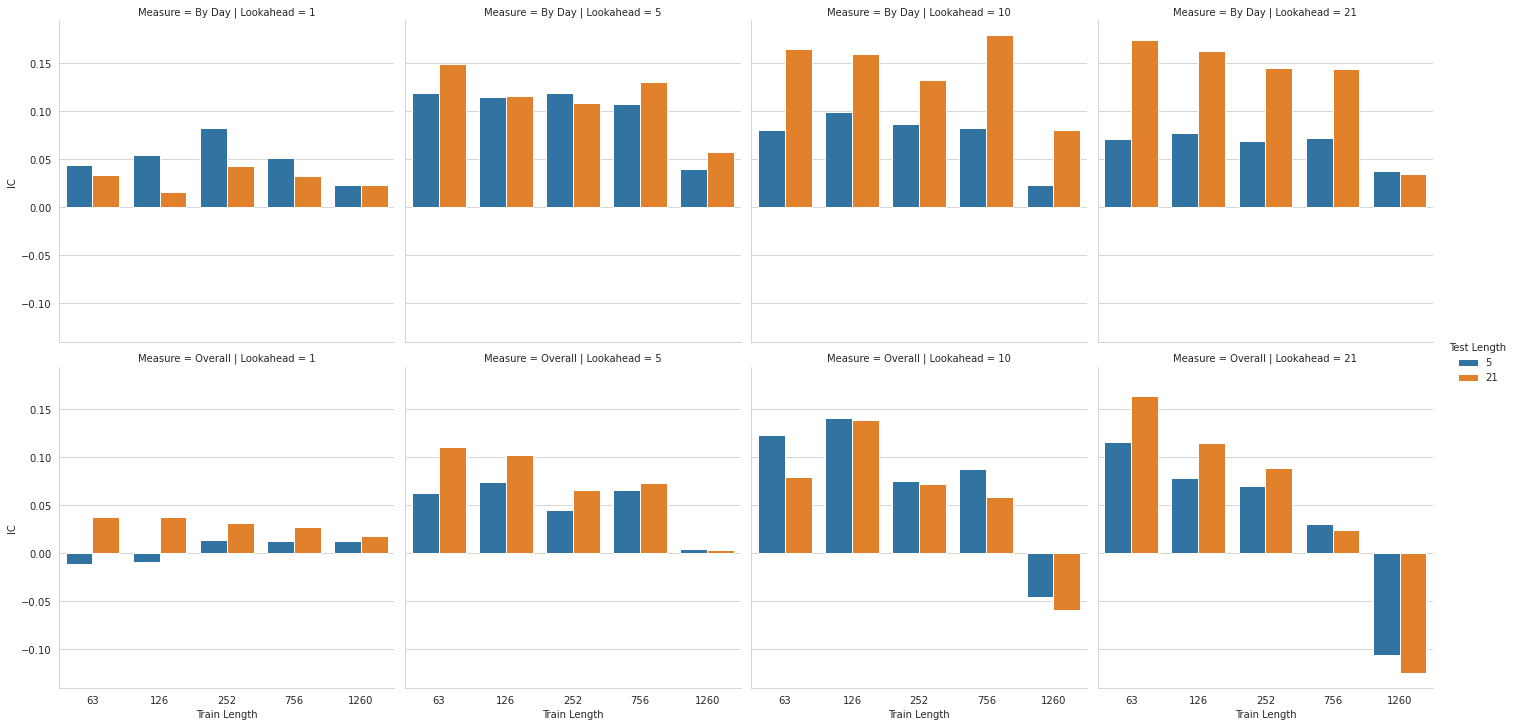

time: 2.56 s (started: 2021-04-29 05:57:30 +00:00)


In [18]:
sns.catplot(x='Train Length',
            y='IC',
            hue='Test Length',
            col='Lookahead',
            row='Measure',
            data=lr_metrics_long,
            kind='bar')

Compare the distributions of each IC metric for the different prediction horizons:

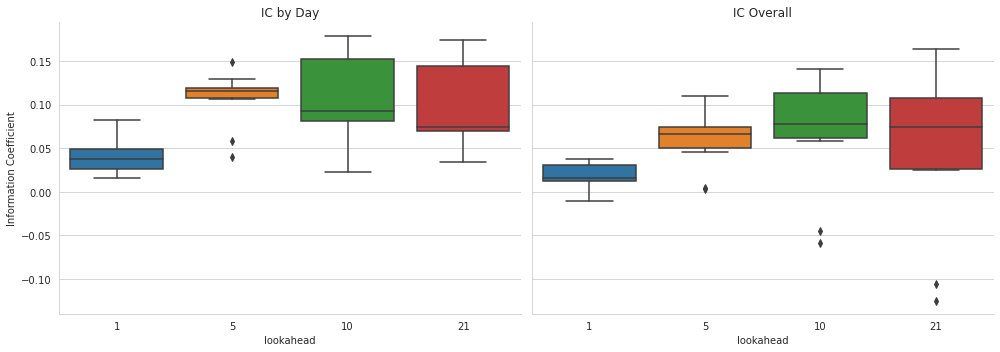

time: 503 ms (started: 2021-04-29 05:57:32 +00:00)


In [19]:
fig, axes =plt.subplots(ncols=2, figsize=(14,5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
sns.despine()
fig.tight_layout()

### Best Train/Test Period Lengths

Show the best train/test period settings for the four prediction horizons:

In [20]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic')))

,lookahead,train_length,test_length,ic_by_day,ic
9,1,63,21,0.033615,0.037822
7,1,126,21,0.015814,0.037618
5,1,252,21,0.042732,0.031847
19,5,63,21,0.148540,0.110126
17,5,126,21,0.115812,0.101829
16,5,126,5,0.114283,0.074268
26,10,126,5,0.098941,0.140911
27,10,126,21,0.158797,0.138540
28,10,63,5,0.080264,0.122674
39,21,63,21,0.174340,0.163393


time: 46.7 ms (started: 2021-04-29 05:57:33 +00:00)


In [21]:
lr_metrics.to_csv(path_result / 'lin_reg_performance.csv', index=False)
!zip stooq_jp_result.zip result/lin_reg_performance.csv

updating: result/lin_reg_performance.csv (deflated 53%)
time: 225 ms (started: 2021-04-29 05:57:33 +00:00)


## LightGBM Random Forest Model Tuning

Helper function to obtain the LightGBM feature importance metrics:

In [22]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

time: 798 µs (started: 2021-04-29 05:57:33 +00:00)


LightGBM base parameter settings that are independent of hyperparameter tuning:

In [23]:
cpu_count = os.cpu_count()
print('# of cpus:', cpu_count)

base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   n_jobs=cpu_count,
                   verbose=-1)

# of cpus: 4
time: 3.21 ms (started: 2021-04-29 05:57:33 +00:00)


### Hyperparameter Options

We run this experiment with different parameters for the bagging and feature fractions that determine the degree of randomization as well as the minimum number of samples for a split to control overfitting:

In [24]:
bagging_fraction_opts = [.5, .75, .95]
feature_fraction_opts = [.75, .95]
min_data_in_leaf_opts = [250, 500, 1000]

time: 10.3 ms (started: 2021-04-29 05:57:33 +00:00)


This gives us 3x2x3=18 parameter combinations:

In [25]:
cv_params = list(product(bagging_fraction_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_cv_params = len(cv_params)
n_cv_params

18

time: 4.43 ms (started: 2021-04-29 05:57:33 +00:00)


#### Random Sample

To limit the running time, we can randomly sample a subset of the parameter combinations (here: 50%):

In [26]:
sample_proportion = .5
#sample_proportion = .2 # testing
sample_size = int(sample_proportion * n_cv_params)

cv_param_sample = np.random.choice(list(range(n_cv_params)), 
                                     size=int(sample_size), 
                                     replace=False)
cv_params_ = [cv_params[i] for i in cv_param_sample]
print('# CV parameters:', len(cv_params_))

# CV parameters: 9
time: 3.55 ms (started: 2021-04-29 05:57:33 +00:00)


We tune the number of trees by evaluating a fully grown forest for various smaller sizes:

In [27]:
num_iterations = [25] + list(range(50, 501, 25))
num_boost_round = num_iterations[-1]

time: 536 µs (started: 2021-04-29 05:57:33 +00:00)


### Train/Test Period Lenghts

As above for linear regression, we define a range of train/test period length:

#### Define parameters

In [30]:
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]
val_length = 2 * YEAR

test_params = list(product(train_lengths, test_lengths))
n_test_params = len(test_params)
n_test_params

10

time: 8.27 ms (started: 2021-04-29 05:59:07 +00:00)


#### Random sample

Just as for the model parameters, we can randomly sample from the 5 x 2 = 10 training configurations (here: 50%):

In [29]:
sample_proportion = 0.5
#sample_proportion = .2 # testing
sample_size = int(sample_proportion * n_test_params)

test_param_sample = np.random.choice(list(range(n_test_params)), 
                                     size=int(sample_size), 
                                     replace=False)
test_params_ = [test_params[i] for i in test_param_sample]
print('lookaheads:', len(lookaheads))
print('Train configs:', len(test_params_))
print('CV Iterations:', len(cv_params_))
print('# of run:', len(lookaheads) * len(test_params_) * len(cv_params_))

lookaheads: 4
Train configs: 5
CV Iterations: 9
# of run: 180
time: 7.27 ms (started: 2021-04-29 05:57:33 +00:00)


### Categorical Variables

To leverage LightGBM's ability to handle categorical variables, we need to define them; we'll also `factorize` them so they are both integer-encoded and start at zero (optional, but otherwise throws a warning) as expected by LightGBM:

In [31]:
cv_data = (pd.read_csv(path_data / 'stooq_jp_equities_cv.csv' , parse_dates=['date'])
             .set_index(['ticker','date'])
             .sort_index(level=['ticker','date'])      
          )
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    cv_data[feature] = pd.factorize(cv_data[feature], sort=True)[0]
cv_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 420082 entries, ('1605.JP', Timestamp('2010-01-04 00:00:00')) to ('9984.JP', Timestamp('2017-12-29 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ret_1            419868 non-null  float64
 1   ret_rel_perc_1   419868 non-null  float64
 2   ret_5            419012 non-null  float64
 3   ret_rel_perc_5   419012 non-null  float64
 4   ret_10           417942 non-null  float64
 5   ret_rel_perc_10  417942 non-null  float64
 6   ret_21           415588 non-null  float64
 7   ret_rel_perc_21  415588 non-null  float64
 8   ret_63           406600 non-null  float64
 9   ret_rel_perc_63  406600 non-null  float64
 10  PPO              414732 non-null  float64
 11  NATR             417086 non-null  float64
 12  RSI              417086 non-null  float64
 13  bbl              419226 non-null  float64
 14  bbu              419226 non-null  float64
 15  we

### Run Cross-Validation

Set up some helper variabels and storage locations to faciliate the CV process and result storage:

In [32]:
labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()
label_dict = dict(zip(lookaheads, labels))

time: 12.1 ms (started: 2021-04-29 05:59:41 +00:00)


In [33]:
ic_cols = ['bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't'] + [str(n) for n in num_iterations]

time: 757 µs (started: 2021-04-29 05:59:42 +00:00)


Now we take the following steps:
- we iterate over the prediction horizons and train/test period length, 
- set up the `MultipleTimeSeriesCV` accordingly
- create the binary LightGBM dataset with the appropriate target, and
- iterate over the model hyperparamters to train and validate the model while capturing the relevant performance metrics:

In [39]:
from google.cloud import storage

def upload_blob(source_file_name, 
                destination_dir='lbk/rf/', 
                bucket_name='finance_data_bucket'):
    """Uploads a file to the bucket."""
    # The ID of your GCS bucket
    # bucket_name = "your-bucket-name"
    # The path to your file to upload
    # source_file_name = "local/path/to/file"
    # The ID of your GCS object
    # destination_blob_name = "storage-object-name"

    destination_blob_name = destination_dir + str(source_file_name).split('/')[-1]
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )

time: 785 µs (started: 2021-04-29 00:53:17 +00:00)


In [ ]:
import pickle

#for lookahead in lookaheads:
for lookahead in lookaheads[1:]: # testing
    lgb_result = {}
    for train_length, test_length in test_params_:
        lgb_result_tmp = {}
        
        n_splits = int(val_length / test_length)
        print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
              f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f}')

        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  train_period_length=train_length,
                                  lookahead=lookahead)

        label = label_dict[lookahead]
        outcome_data = cv_data.loc[:, features + [label]].dropna()

        lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                               label=outcome_data[label],
                               categorical_feature=categoricals,
                               free_raw_data=False)
        predictions, daily_ic, ic, feature_importance = [], [], [], []
        key = f'{lookahead}/{train_length}/{test_length}'
        T = 0
        for p, (bagging_fraction, feature_fraction, min_data_in_leaf) in enumerate(cv_params_):
            params = base_params.copy()
            params.update(dict(bagging_fraction=bagging_fraction,
                               feature_fraction=feature_fraction,
                               min_data_in_leaf=min_data_in_leaf))

            start = time()
            cv_preds, nrounds = [], []
            for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
                #lgb_train = lgb_data.subset(train_idx.tolist()).construct()
                #lgb_test = lgb_data.subset(test_idx.tolist()).construct()
                lgb_train = lgb_data.subset(train_idx.tolist())
                lgb_test = lgb_data.subset(test_idx.tolist())

                model = lgb.train(params=params,
                                  train_set=lgb_train,
                                  num_boost_round=num_boost_round,
                                  categorical_feature=categoricals, 
                                  verbose_eval=False)
                if i == 0:
                    fi = get_fi(model).to_frame()
                else:
                    fi[i] = get_fi(model)

                test_set = outcome_data.iloc[test_idx, :]
                X_test = test_set.loc[:, model.feature_name()]
                y_test = test_set.loc[:, label]
                y_pred = {str(n): model.predict(X_test, num_iteration=n)
                          for n in num_iterations}
                cv_preds.append(y_test.to_frame(
                    'y_test').assign(**y_pred).assign(i=i))
                nrounds.append(model.best_iteration)
            feature_importance.append(fi.T.describe().T.assign(bagging_fraction=bagging_fraction,
                                                               feature_fraction=feature_fraction,
                                                               min_data_in_leaf=min_data_in_leaf))
            cv_preds = pd.concat(cv_preds).assign(bagging_fraction=bagging_fraction,
                                                  feature_fraction=feature_fraction,
                                                  min_data_in_leaf=min_data_in_leaf)

            #predictions.append(cv_preds)
            by_day = cv_preds.groupby(level='date')
            ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test,
                                                                    x[str(n)])[0]).to_frame(n)
                                   for n in num_iterations], axis=1)

            daily_ic.append(ic_by_day.assign(bagging_fraction=bagging_fraction,
                                             feature_fraction=feature_fraction,
                                             min_data_in_leaf=min_data_in_leaf))

            cv_ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0]
                  for n in num_iterations]

            T += time() - start
            ic.append([bagging_fraction, feature_fraction,
                       min_data_in_leaf, lookahead] + cv_ic)

            msg = f'{p:3.0f} | {format_time(T)} | '
            msg += f'{bagging_fraction:3.0%} | {feature_fraction:3.0%} | {min_data_in_leaf:5,.0f} | '
            msg += f'{max(cv_ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {ic_by_day.median().max(): 6.2%}'
            print(msg)
            
        lgb_result['ic/' + key] = lgb_result_tmp['ic/' + key] = pd.DataFrame(ic, columns=ic_cols)
        lgb_result['daily_ic/' + key] = lgb_result_tmp['daily_ic/' + key] = pd.concat(daily_ic)
        lgb_result['fi/' + key] = lgb_result_tmp['fi/' + key] = pd.concat(feature_importance)
        #lgb_result['predictions/' + key] = pd.concat(predictions)
        
        fname = f'rf_reg_tuning_{lookahead}_tmp_{train_length}_{test_length}.pickle'
        with open(path_result / fname, 'wb') as handle: # save to data dir
            pickle.dump(lgb_result_tmp, handle)
        upload_blob(path_result / fname)
        
    fname = f'rf_reg_tuning_{lookahead}.pickle'
    with open(path_result / fname, 'wb') as handle: # save to data dir
        pickle.dump(lgb_result, handle)

Lookahead:  5 | Train:  63 | Test: 21 | Params:   9
  0 | 00:00:47 | 50% | 75% |   250 |  4.31% |  2.22% |  1.88%
  1 | 00:01:26 | 50% | 75% |   500 |  3.78% |  1.90% |  1.70%
  2 | 00:01:59 | 75% | 75% | 1,000 |  4.40% |  1.79% |  1.62%
  3 | 00:02:31 | 50% | 95% | 1,000 |  2.59% |  1.74% |  1.80%
  4 | 00:03:20 | 50% | 95% |   250 |  3.96% |  2.76% |  2.93%
  5 | 00:04:03 | 95% | 75% |   500 |  4.03% |  2.36% |  1.65%
  6 | 00:04:47 | 95% | 95% |   500 |  3.52% |  2.60% |  2.43%
  7 | 00:05:40 | 95% | 95% |   250 |  3.13% |  3.15% |  3.21%
  8 | 00:06:15 | 75% | 95% | 1,000 |  5.08% |  1.75% |  1.33%
File /home/jupyter/random_forests/result/rf_reg_tuning_5_tmp_63_21.pickle uploaded to lbk/rf/rf_reg_tuning_5_tmp_63_21.pickle.
Lookahead:  5 | Train: 756 | Test:  5 | Params:   9
  0 | 00:09:52 | 50% | 75% |   250 | -2.21% |  0.76% |  0.93%
  1 | 00:20:03 | 50% | 75% |   500 | -2.72% |  1.50% |  1.14%
  2 | 00:29:05 | 75% | 75% | 1,000 | -4.26% |  1.67% |  1.40%
  3 | 00:40:24 | 50% | 95

In [ ]:
!zip stooq_jp_result_cv.zip result/*pickle

## Analyse Cross-Validation Results

### Collect Data

We'll now combine the CV results that we stored separately for each fold (to avoid loosing results in case something goes wrong along the way):

In [4]:
!gsutil cp gs://finance_data_bucket/lbk/rf/*tmp*pickle result/

Copying gs://finance_data_bucket/lbk/rf/rf_reg_tuning_10_tmp_63_21.pickle...
Copying gs://finance_data_bucket/lbk/rf/rf_reg_tuning_10_tmp_756_5.pickle...    
Copying gs://finance_data_bucket/lbk/rf/rf_reg_tuning_1_tmp_1260_5.pickle...    
Copying gs://finance_data_bucket/lbk/rf/rf_reg_tuning_1_tmp_126_21.pickle...    
- [4 files][  3.4 MiB/  3.4 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://finance_data_bucket/lbk/rf/rf_reg_tuning_1_tmp_126_5.pickle...
Copying gs://finance_data_bucket/lbk/rf/rf_reg_tuning_1_tmp_63_21.pickle...     
Copying gs://finance_data_bucket/lbk/rf/rf_reg_tuning_1_tmp_63_5.pickle...      
Copying gs://finance_data_bucket/lbk/rf/rf_reg_tuning_1_tmp_756_5.pickle...     
Copying gs://finance_data_bu

In [5]:
# concat cv result
from os import listdir
from os.path import isfile, join
files = [f for f in listdir(path_result) if isfile(join(path_result, f))]
#files = [f for f in files if f.endswith('pickle')]
files = [f for f in files if f.endswith('pickle') and f.find('tmp') > 0]

import pickle
lgb_result = {}
for fname_pickle in files:
    with open(path_result / fname_pickle, 'rb') as handle:
        lgb_result.update(pickle.load(handle))
lgb_result.keys()

dict_keys(['ic/1/63/5', 'daily_ic/1/63/5', 'fi/1/63/5', 'ic/1/126/5', 'daily_ic/1/126/5', 'fi/1/126/5', 'ic/5/63/5', 'daily_ic/5/63/5', 'fi/5/63/5', 'ic/5/756/5', 'daily_ic/5/756/5', 'fi/5/756/5', 'ic/1/126/21', 'daily_ic/1/126/21', 'fi/1/126/21', 'ic/1/1260/5', 'daily_ic/1/1260/5', 'fi/1/1260/5', 'ic/5/126/5', 'daily_ic/5/126/5', 'fi/5/126/5', 'ic/10/63/21', 'daily_ic/10/63/21', 'fi/10/63/21', 'ic/5/1260/5', 'daily_ic/5/1260/5', 'fi/5/1260/5', 'ic/10/756/5', 'daily_ic/10/756/5', 'fi/10/756/5', 'ic/1/63/21', 'daily_ic/1/63/21', 'fi/1/63/21', 'ic/5/63/21', 'daily_ic/5/63/21', 'fi/5/63/21', 'ic/1/756/5', 'daily_ic/1/756/5', 'fi/1/756/5'])

time: 39.6 ms (started: 2021-05-01 02:22:48 +00:00)


In [6]:
try:
    lookaheads
except NameError:
    lookaheads = [1, 5, 10, 21]

time: 487 µs (started: 2021-05-01 02:22:50 +00:00)


In [7]:
id_vars = ['train_length',
           'test_length',
           'bagging_fraction',
           'feature_fraction',
           'min_data_in_leaf',
           't', 'date']

time: 420 µs (started: 2021-05-01 02:22:50 +00:00)


We'll look at the financial performance in the notebook `alphalens_signal_quality`.

In [8]:
daily_ic, ic = [], []
for t in lookaheads:
    print('lookahead:', t)
    store = lgb_result
    keys = [k[1:] for k in store.keys() if k.startswith(f'fi/{t}')]
    for key in keys:
        train_length, test_length = key.split('/')[2:]
        print('train/test length:', train_length, test_length)
        k = f'{t}/{train_length}/{test_length}'
        cols = {'t': t,
                'train_length': int(train_length),
                'test_length': int(test_length)}

        ic.append(pd.melt(store['ic/' + k]
                          .assign(**cols),
                          id_vars=id_vars[:-1],
                          value_name='ic',
                          var_name='rounds')
                  .apply(pd.to_numeric))

        df = store['daily_ic/' + k].assign(**cols).reset_index()
        daily_ic.append(pd.melt(df,
                                id_vars=id_vars,
                                value_name='daily_ic',
                                var_name='rounds')
                        .set_index('date')
                        .apply(pd.to_numeric)
                        .reset_index())            
ic = pd.concat(ic, ignore_index=True)
daily_ic = pd.concat(daily_ic, ignore_index=True)

lookahead: 1
train/test length: 63 5
train/test length: 126 5
train/test length: 126 21
train/test length: 1260 5
train/test length: 63 21
train/test length: 756 5
train/test length: 63 21
train/test length: 756 5
lookahead: 5
train/test length: 63 5
train/test length: 756 5
train/test length: 126 5
train/test length: 1260 5
train/test length: 63 21
lookahead: 10
train/test length: 63 21
train/test length: 756 5
lookahead: 21
time: 734 ms (started: 2021-05-01 02:22:53 +00:00)


### Predictive Performance: CV Information Coefficient by Day

We first look at the daily IC, the metric we ultimately care about for a daily trading strategy. The best results for all prediction horizons are typically achieved with three years of training; the shorter horizons work better with 21 day testing period length. More regularization often improves the result but the impact of the bagging and feature fraction parameters are a little less clear cut and likely depend on other parameters.

In [9]:
group_cols = ['t','train_length', 'test_length', 
              'bagging_fraction', 'feature_fraction', 'min_data_in_leaf']
daily_ic_avg = daily_ic.groupby(group_cols + ['rounds']).daily_ic.mean().to_frame('ic').reset_index()
daily_ic_avg.groupby('t', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,t,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,rounds,ic
440,1,126,21,0.50,0.95,500,25,0.018387
441,1,126,21,0.50,0.95,500,50,0.016734
442,1,126,21,0.50,0.95,500,75,0.016595
1280,5,63,21,0.95,0.95,250,25,0.031504
1282,5,63,21,0.95,0.95,250,75,0.030605
1283,5,63,21,0.95,0.95,250,100,0.030530
1977,10,63,21,0.75,0.95,1000,450,0.017853
1978,10,63,21,0.75,0.95,1000,475,0.017769
1979,10,63,21,0.75,0.95,1000,500,0.017702


time: 255 ms (started: 2021-05-01 02:22:59 +00:00)


In [20]:
daily_ic_avg.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 900 non-null    int64  
 1   train_length      900 non-null    int64  
 2   test_length       900 non-null    int64  
 3   bagging_fraction  900 non-null    float64
 4   feature_fraction  900 non-null    float64
 5   min_data_in_leaf  900 non-null    int64  
 6   rounds            900 non-null    int64  
 7   ic                900 non-null    float64
dtypes: float64(3), int64(5)
memory usage: 56.4 KB
time: 15.9 ms (started: 2021-04-29 00:35:12 +00:00)


In [18]:
daily_ic_avg.head()

,t,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,rounds,ic
0,1,63,5,0.5,0.75,250,25,0.005485
1,1,63,5,0.5,0.75,250,50,0.004826
2,1,63,5,0.5,0.75,250,75,0.005358
3,1,63,5,0.5,0.75,250,100,0.004369
4,1,63,5,0.5,0.75,250,125,0.003739


time: 10.2 ms (started: 2021-04-30 14:05:21 +00:00)


In [11]:
# save to use for prediction
daily_ic_avg.to_csv(path_result / 'daily_ic_avg.csv', index=False)
!zip -u stooq_jp_result.zip result/daily_ic_avg.csv

  adding: result/daily_ic_avg.csv (deflated 72%)
time: 250 ms (started: 2021-05-01 02:23:50 +00:00)


For a 1-day forecast horizon, over 75% of the predictions yield a positive daily IC; the same is true for 21 days which, unsurprisingly, also shows a wider range.

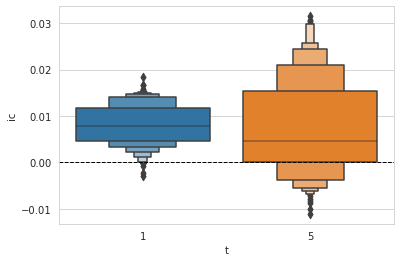

time: 264 ms (started: 2021-04-29 06:00:28 +00:00)


In [39]:
ax = sns.boxenplot(x='t', y='ic', data=daily_ic_avg)
ax.axhline(0, ls='--', lw=1, c='k');

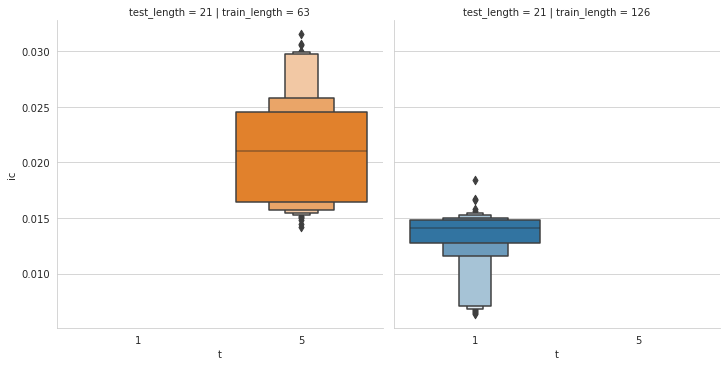

time: 954 ms (started: 2021-04-29 06:00:35 +00:00)


In [40]:
#test_length = 5
test_length = 21
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=daily_ic_avg[(daily_ic_avg.test_length == test_length)],
                kind='boxen')
g.savefig(path_result / f'daily_ic_test_{test_length:02}', dpi=300);

### HyperParameter Impact: Linear Regression

To get a better idea of how the various CV parameters impact the forecast quality, we can run a linear regression with the daily IC as outcome and the one-hot encoded hyperparameters as inputs:

In [44]:
lin_reg = {}
for t in [1, 5]:
#for t in [1]: # testing
    df_ = daily_ic_avg[(daily_ic_avg.t==t)&(daily_ic_avg.rounds<=250)].dropna()
    y, X = df_.ic, df_.drop(['ic', 't'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(
        columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err',
                     't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(path_result / f'lr_result_{t:02}.csv', index=False)

time: 96 ms (started: 2021-04-29 06:01:37 +00:00)


In [45]:
def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith(
        'date') & (coefs.variable != 'const')]
    #coefs.variable = coefs.variable.str.split('_').str[-1]

    coefs.plot(x='variable', y='coef', kind='bar', ax=ax, 
               color='none', capsize=3, yerr='error', legend=False, rot=0)    
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

time: 1.26 ms (started: 2021-04-29 06:01:39 +00:00)


The below plot shows the regression coefficient values and their confidence intervals. The intercept (not shown) has a small positive value and is statistically signifant; it captures the impact of the dropped categories (the smallest value for each parameter).

For 1-day forecasts, some but not all results are insightful: 21-day testing is better, and so is `min_samples_leaf` of 500 or 1,000. 100-200 trees seem to work best, but both shorter and longer training periods are better than intermediate values.

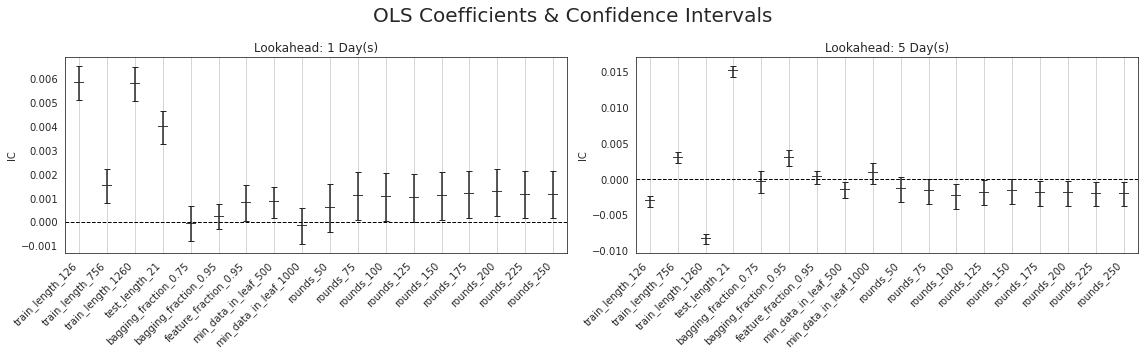

time: 1.19 s (started: 2021-04-29 06:04:15 +00:00)


In [49]:
with sns.axes_style('white'):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    axes = axes.flatten()
    for i, t in enumerate([1, 5]):
        visualize_lr_result(lin_reg[t], axes[i])
        axes[i].set_title(f'Lookahead: {t} Day(s)')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation = 45, ha="right")
        axes[i].grid(axis='x')
    fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.84)

### Information Coefficient: Overall

We'll also take a look at the overall IC value, which is often reported but does not necessarily match the goal of a daily trading strategy that uses the model return predictions as well as the daily IC.

In [50]:
ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620 entries, 0 to 1619
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   train_length      1620 non-null   int64  
 1   test_length       1620 non-null   int64  
 2   bagging_fraction  1620 non-null   float64
 3   feature_fraction  1620 non-null   float64
 4   min_data_in_leaf  1620 non-null   int64  
 5   t                 1620 non-null   int64  
 6   rounds            1620 non-null   int64  
 7   ic                1620 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 101.4 KB
time: 11.9 ms (started: 2021-04-29 06:04:35 +00:00)


#### Best Parameters

Directionally, and for shorter periods, similar hyperparameter settings work best (while the IC values are higher):

In [51]:
ic.groupby('t').apply(lambda x: x.nlargest(3, 'ic'))

train_length  test_length  bagging_fraction  feature_fraction  \
t                                                                       
1 727            756            5              0.95              0.95   
  736            756            5              0.95              0.95   
  745            756            5              0.95              0.95   
5 1448            63           21              0.75              0.95   
  1457            63           21              0.75              0.95   
  1475            63           21              0.75              0.95   

        min_data_in_leaf  t  rounds        ic  
t                                              
1 727                250  1      25  0.013029  
  736                250  1      50  0.009372  
  745                250  1      75  0.008658  
5 1448              1000  5      25  0.050784  
  1457              1000  5      50  0.046903  
  1475              1000  5     100  0.046812

time: 28.8 ms (started: 2021-04-29 06:04:37 +00:00)


#### Visualiztion

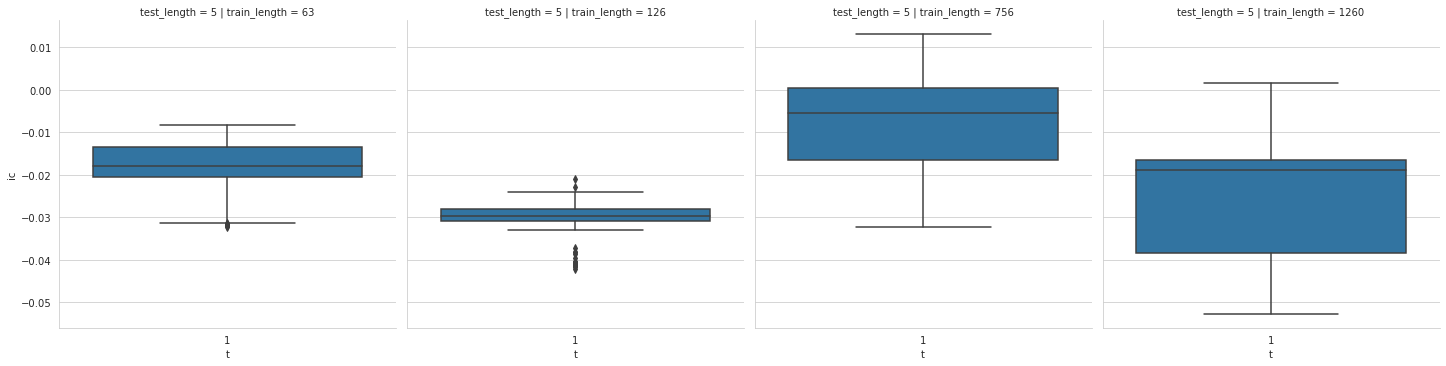

time: 899 ms (started: 2021-04-29 06:04:48 +00:00)


In [52]:
test_length = 5
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=ic[(ic.test_length == test_length) & (ic.t < test_length)],
                kind='box')

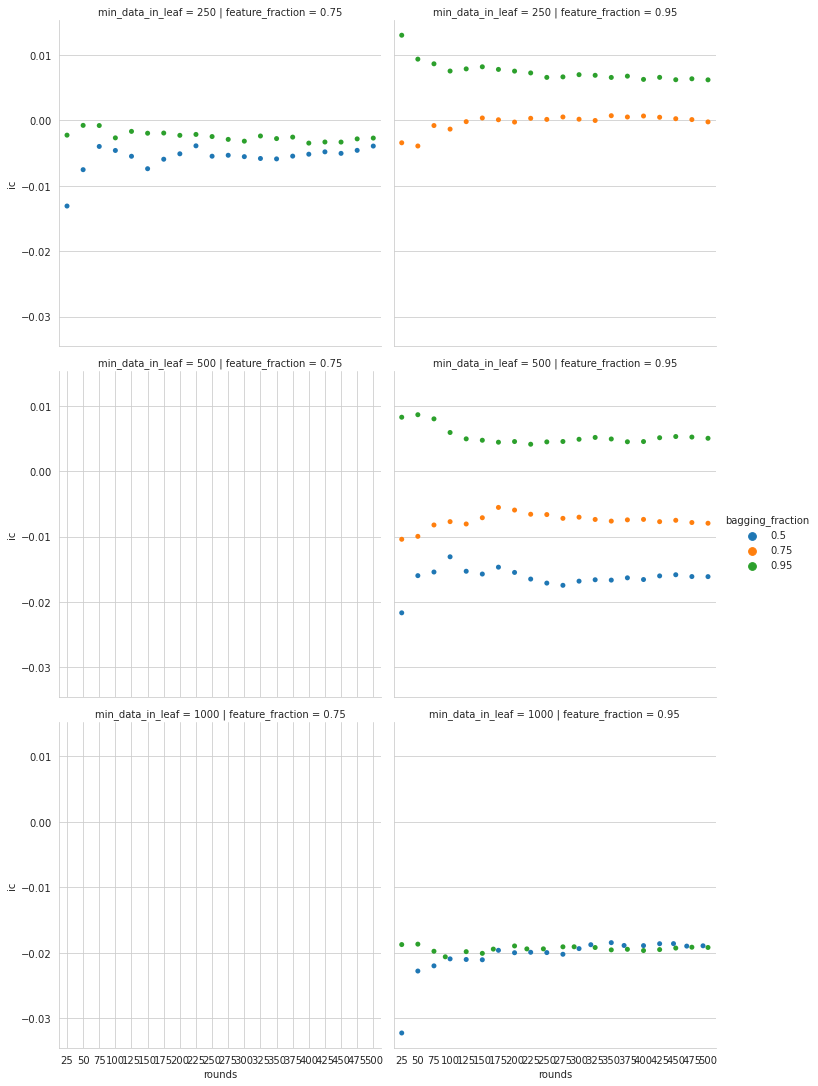

time: 9.65 s (started: 2021-04-29 06:05:13 +00:00)


In [54]:
t = 1
train_length = 756
test_length = 5
g = sns.catplot(x='rounds',
    y='ic',
    col='feature_fraction',
    hue='bagging_fraction',
    row='min_data_in_leaf',
    data=ic[(ic.t == t) &
            (ic.train_length == train_length) &
            (ic.test_length == test_length)],
    kind='swarm');

### Random Forest vs Linear Regression 

Let's compare the best-performing (in-sample) random forest models to our linear regression baseline:

In [55]:
lr_metrics = pd.read_csv(path_result / 'lin_reg_performance.csv')
lr_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lookahead     40 non-null     int64  
 1   train_length  40 non-null     int64  
 2   test_length   40 non-null     int64  
 3   ic_by_day     40 non-null     float64
 4   ic            40 non-null     float64
dtypes: float64(2), int64(3)
memory usage: 1.7 KB
time: 15.3 ms (started: 2021-04-29 06:05:48 +00:00)


In [56]:
daily_ic_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620 entries, 0 to 1619
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   t                 1620 non-null   int64  
 1   train_length      1620 non-null   int64  
 2   test_length       1620 non-null   int64  
 3   bagging_fraction  1620 non-null   float64
 4   feature_fraction  1620 non-null   float64
 5   min_data_in_leaf  1620 non-null   int64  
 6   rounds            1620 non-null   int64  
 7   ic                1620 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 101.4 KB
time: 15.5 ms (started: 2021-04-29 06:05:49 +00:00)


The results are mixed: for the shortest and longest horizons, the random forest outperforms (slightly for 1 day), while linear regression is competitive for the intermediate horizons:

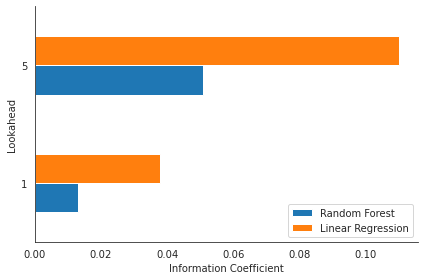

time: 378 ms (started: 2021-04-29 06:05:52 +00:00)


In [57]:
with sns.axes_style("white"):
    ax = (ic.groupby('t').ic.max().to_frame('Random Forest')
     .join(lr_metrics.groupby('lookahead').ic.max().to_frame('Linear Regression')).plot.barh())
    ax.set_ylabel('Lookahead')
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout();

## Generate predictions

To build and evaluate a trading strategy, we create predictions for the 2017-19 period using the 10 best models that we then ensemble:

In [7]:
!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_data.zip .
!unzip stooq_jp_data.zip

Copying gs://finance_data_bucket/lbk/rf/stooq_jp_data.zip...
- [1 files][401.4 MiB/401.4 MiB]                                                
Operation completed over 1 objects/401.4 MiB.                                    
Archive:  stooq_jp_data.zip
  inflating: data/stooq_jp_tse_stocks_prices.csv  
  inflating: data/stooq_jp_tse_stocks_tickers.csv  
  inflating: data/stooq_jp_equities.csv  
time: 24.2 s (started: 2021-04-30 13:58:52 +00:00)


In [ ]:
!gsutil cp gs://finance_data_bucket/lbk/rf/stooq_jp_result.zip .
!unzip stooq_jp_result.zip

In [9]:
param_cols = ['train_length', 'test_length', 'bagging_fraction',
              'feature_fraction', 'min_data_in_leaf', 'rounds']

time: 552 µs (started: 2021-05-01 13:57:01 +00:00)


In [10]:
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]
val_length = 2 * YEAR

time: 649 µs (started: 2021-05-01 13:57:03 +00:00)


In [11]:
def get_params(data, t=5, best=0):
    df = data[data.t == t].sort_values('ic', ascending=False).iloc[best]
    df = df.loc[param_cols]
    rounds = int(df.rounds)
    params = pd.to_numeric(df.drop('rounds'))
    return params, rounds

time: 769 µs (started: 2021-05-01 13:57:04 +00:00)


In [12]:
cpu_count = os.cpu_count()
print('# of cpus:', cpu_count)

base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   n_jobs=cpu_count,
                   verbose=-1)

# of cpus: 2
time: 947 µs (started: 2021-05-01 13:57:06 +00:00)


In [13]:
daily_ic_avg = pd.read_csv(path_result / 'daily_ic_avg.csv')
daily_ic_avg.head()

,t,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,rounds,ic
0,1,63,5,0.5,0.75,250,25,0.005485
1,1,63,5,0.5,0.75,250,50,0.004826
2,1,63,5,0.5,0.75,250,75,0.005358
3,1,63,5,0.5,0.75,250,100,0.004369
4,1,63,5,0.5,0.75,250,125,0.003739


time: 43 ms (started: 2021-05-01 13:57:08 +00:00)



Lookahead: 01
Position: 00


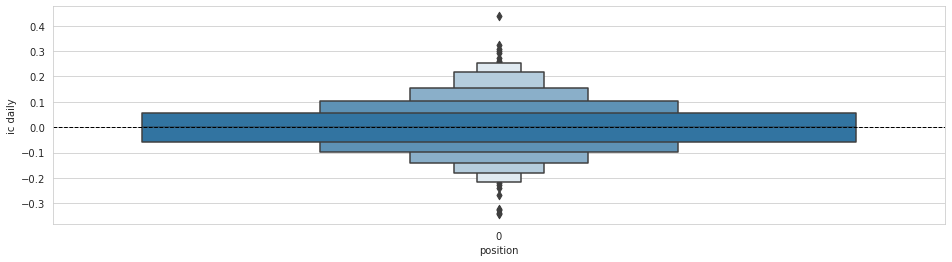

time: 34.4 s (started: 2021-05-01 14:13:11 +00:00)


In [18]:
num_models = 10

for lookahead in [1, 5, 10, 21]:
    if lookahead > 1: 
        continue
    print(f'\nLookahead: {lookahead:02}')
    data = (pd.read_csv(path_data / 'stooq_jp_equities.csv', parse_dates=['date'])
              .set_index(['ticker','date'])
              .sort_index(level=['ticker','date'])
              .loc[idx[:, '2010': '2018'], :]
              )
    labels = sorted(data.filter(like='fwd').columns)
    features = data.columns.difference(labels).tolist()
    label = f'fwd_ret_{lookahead:02}'
    #data = data.loc[:, features + [label]].dropna()
    data = data.loc[:, features + [label]] # keep rows of no label for trading purpose

    categoricals = ['year', 'weekday', 'month']
    for feature in categoricals:
        data[feature] = pd.factorize(data[feature], sort=True)[0]

    lgb_data = lgb.Dataset(data=data[features],
                           label=data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    
    for position in range(num_models):
        params, num_boost_round = get_params(daily_ic_avg,
                                             t=lookahead,
                                             best=position)
        params = params.to_dict()
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
        train_length = int(params.pop('train_length'))
        test_length = int(params.pop('test_length'))
        params.update(base_params)

        print(f'Position: {position:02}')

        n_splits = int(val_length / test_length)
        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  lookahead=lookahead,
                                  train_period_length=train_length)

        predictions = []
        start = time()
        for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
            train_set = lgb_data.subset(used_indices=train_idx.tolist(),
                                        #params=params).construct()
                                        params=params)
    
            model = lgb.train(params=params,
                              train_set=train_set,
                              num_boost_round=num_boost_round,
                              categorical_feature=categoricals, 
                              verbose_eval=False)
        
            test_set = data.iloc[test_idx, :]
            y_test = test_set.loc[:, label].to_frame('y_test')
            y_pred = model.predict(test_set.loc[:, model.feature_name()])
            predictions.append(y_test.assign(prediction=y_pred))
            #train_test_periods_msg(train_idx, test_idx, data)
            
        if position == 0:
            test_predictions = (pd.concat(predictions)
                                .rename(columns={'prediction': position}))
        else:
            test_predictions[position] = pd.concat(predictions).prediction
        
    by_day = test_predictions.groupby(level='date')
    for position in range(num_models):
        if position == 0:
            ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
        else:
            ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])
    test_predictions = test_predictions.sort_index(level=['ticker','date'])
    test_predictions.to_csv(path_result / f'test_{lookahead:02}.csv')

# plot ic
fig, ax = plt.subplots(figsize=(16, 4))
sns.boxenplot(x='position', y='ic daily', 
                   data=pd.melt(ic_by_day).rename(columns={'variable':'position', 'value':'ic daily'}),
                   ax=ax )
ax.axhline(0, ls='--', lw=1, c='k');

In [19]:
test_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 474264 entries, ('1332.JP', Timestamp('2016-12-14 00:00:00')) to ('9990.JP', Timestamp('2018-12-28 00:00:00'))
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y_test  474264 non-null  float64
 1   0       474264 non-null  float64
dtypes: float64(2)
memory usage: 9.1+ MB
time: 20.3 ms (started: 2021-05-01 14:13:45 +00:00)


In [64]:
!unzip -l stooq_jp_result.zip

Archive:  stooq_jp_result.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
     2018  2021-04-29 05:57   result/lin_reg_performance.csv
---------                     -------
     2018                     1 file
time: 179 ms (started: 2021-04-29 08:46:34 +00:00)


In [65]:
!zip -u stooq_jp_result.zip result/test_01.csv

  adding: result/test_01.csv (deflated 60%)
time: 11.9 s (started: 2021-04-29 08:46:54 +00:00)


In [ ]:
!gsutil cp stooq_jp_result.zip gs://finance_data_bucket/lbk/rf/